# TMDB Movie Rating Prediction - Machine Learning Regression Analysis

By:
- Ahmad Zaky Ash Shidqi - 5025231229
- Machine Learning - H

# Introduction 
Di notebook ini, akan diprediksi rating film (vote_average) menggunakan berbagai fitur dari Dataset TMDB 5000 Movie. Menggunakan teknik regresi untuk membangun model prediksi dan menganalisis faktor-faktor yang paling mempengaruhi rating film.

**Tujuan:**  
- Memprediksi rating film berdasarkan berbagai fitur  
- Mengidentifikasi faktor kunci yang mempengaruhi kesuksesan film  
- Membandingkan berbagai algoritma regresi  
- Memahami pentingnya fitur dalam prediksi rating film  

### Data Loading and Exploration

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

Load Dataset

In [8]:
movies_df = pd.read_csv('tmdb_5000_movies.csv')
credits_df = pd.read_csv('tmdb_5000_credits.csv')

print("Movies Dataset Shape:", movies_df.shape)
print("Credits Dataset Shape:", credits_df.shape)

Movies Dataset Shape: (4803, 20)
Credits Dataset Shape: (4803, 4)


Display basic information about the datasets

In [10]:
print("=== MOVIES DATASET INFO ===")
print(movies_df.info())
print("\n=== CREDITS DATASET INFO ===")
print(credits_df.info())

=== MOVIES DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object

In [11]:
print("=== MOVIES DATASET HEAD ===")
print(movies_df.head())
print("\n=== CREDITS DATASET HEAD ===")
print(credits_df.head())

=== MOVIES DATASET HEAD ===
      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...              

Check for missing values

In [13]:
print("=== MISSING VALUES IN MOVIES ===")
print(movies_df.isnull().sum())
print("\n=== MISSING VALUES IN CREDITS ===")
print(credits_df.isnull().sum())

=== MISSING VALUES IN MOVIES ===
budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

=== MISSING VALUES IN CREDITS ===
movie_id    0
title       0
cast        0
crew        0
dtype: int64


### Data Preprocessing

Merge Dataset

In [16]:
print("Movies columns:", movies_df.columns.tolist())
print("Credits columns:", credits_df.columns.tolist())

df = movies_df.merge(credits_df, left_on='id', right_on='movie_id', how='left')
print("Merged dataset shape:", df.shape)

Movies columns: ['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']
Credits columns: ['movie_id', 'title', 'cast', 'crew']
Merged dataset shape: (4803, 24)


In [17]:
# Function to safely parse JSON strings
def safe_json_loads(x):
    try:
        return json.loads(x.replace("'", '"')) if pd.notna(x) else []
    except:
        return []

# Function to extract names from JSON list
def extract_names(json_list, key='name', limit=None):
    if isinstance(json_list, str):
        json_list = safe_json_loads(json_list)
    if isinstance(json_list, list):
        names = [item.get(key, '') for item in json_list if isinstance(item, dict)]
        return names[:limit] if limit else names
    return []

# Function to extract first name only
def extract_first_name(json_list, key='name'):
    names = extract_names(json_list, key)
    return names[0] if names else ''

In [18]:
# Parse JSON columns and extract useful features
print("Extracting features from JSON columns...")

# Extract genres
df['genres_list'] = df['genres'].apply(lambda x: extract_names(x))
df['num_genres'] = df['genres_list'].apply(len)
df['primary_genre'] = df['genres'].apply(lambda x: extract_first_name(x))

# Extract production companies
df['production_companies_list'] = df['production_companies'].apply(lambda x: extract_names(x))
df['num_production_companies'] = df['production_companies_list'].apply(len)
df['primary_production_company'] = df['production_companies'].apply(lambda x: extract_first_name(x))

# Extract production countries
df['production_countries_list'] = df['production_countries'].apply(lambda x: extract_names(x))
df['num_production_countries'] = df['production_countries_list'].apply(len)
df['primary_production_country'] = df['production_countries'].apply(lambda x: extract_first_name(x))

# Extract spoken languages
df['spoken_languages_list'] = df['spoken_languages'].apply(lambda x: extract_names(x))
df['num_spoken_languages'] = df['spoken_languages_list'].apply(len)

# Extract keywords
df['keywords_list'] = df['keywords'].apply(lambda x: extract_names(x))
df['num_keywords'] = df['keywords_list'].apply(len)

Extracting features from JSON columns...


In [19]:
# Parse cast and crew information
print("Extracting cast and crew features...")

# Extract cast information
df['cast_list'] = df['cast'].apply(lambda x: extract_names(x, 'name'))
df['num_cast'] = df['cast_list'].apply(len)
df['lead_actor'] = df['cast'].apply(lambda x: extract_first_name(x, 'name'))

# Extract crew information (focus on director)
def extract_directors(crew_json):
    if isinstance(crew_json, str):
        crew_list = safe_json_loads(crew_json)
        directors = [person.get('name', '') for person in crew_list 
                    if isinstance(person, dict) and person.get('job') == 'Director']
        return directors[0] if directors else ''
    return ''

df['director'] = df['crew'].apply(extract_directors)

Extracting cast and crew features...


In [20]:
# Handle date features
print("Processing date features...")

df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.day

# Calculate movie age (assuming current year is 2024)
current_year = 2024
df['movie_age'] = current_year - df['release_year']

Processing date features...


In [21]:
# Handle missing values and create derived features
print("Creating derived features...")

# Fill missing values
df['runtime'].fillna(df['runtime'].median(), inplace=True)
df['budget'].fillna(0, inplace=True)
df['revenue'].fillna(0, inplace=True)

# Create derived features
df['profit'] = df['revenue'] - df['budget']
df['roi'] = np.where(df['budget'] > 0, df['profit'] / df['budget'], 0)
df['budget_per_minute'] = np.where(df['runtime'] > 0, df['budget'] / df['runtime'], 0)
df['revenue_per_minute'] = np.where(df['runtime'] > 0, df['revenue'] / df['runtime'], 0)

# Create budget and revenue categories
df['budget_category'] = pd.cut(df['budget'], 
                              bins=[0, 1000000, 10000000, 100000000, float('inf')],
                              labels=['Low', 'Medium', 'High', 'Blockbuster'])

df['is_profitable'] = (df['profit'] > 0).astype(int)

Creating derived features...


### Feature Engineering

In [23]:
# Prepare features for modeling
print("Preparing features for modeling...")

# Select numerical features
numerical_features = [
    'budget', 'popularity', 'runtime', 'vote_count', 'revenue',
    'num_genres', 'num_production_companies', 'num_production_countries',
    'num_spoken_languages', 'num_keywords', 'num_cast',
    'release_year', 'release_month', 'movie_age',
    'profit', 'roi', 'budget_per_minute', 'revenue_per_minute'
]

# Select categorical features
categorical_features = [
    'original_language', 'status', 'primary_genre',
    'primary_production_company', 'primary_production_country',
    'director', 'lead_actor', 'budget_category'
]

# Target variable
target = 'vote_average'

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

Preparing features for modeling...
Numerical features: 18
Categorical features: 8


In [24]:
# Handle categorical variables
print("Encoding categorical variables...")

# Create a copy for modeling
model_df = df.copy()

# Remove rows with missing target values
model_df = model_df.dropna(subset=[target])

# For high cardinality categorical features, keep only top categories
def reduce_categories(series, top_n=10):
    top_categories = series.value_counts().head(top_n).index
    return series.where(series.isin(top_categories), 'Other')

high_cardinality_features = ['primary_production_company', 'director', 'lead_actor']
for feature in high_cardinality_features:
    if feature in model_df.columns:
        model_df[feature] = reduce_categories(model_df[feature])

# One-hot encode categorical features
categorical_df = pd.get_dummies(model_df[categorical_features], prefix=categorical_features)

# Combine numerical and categorical features
feature_df = pd.concat([
    model_df[numerical_features],
    categorical_df
], axis=1)

# Handle any remaining missing values
feature_df = feature_df.fillna(0)

print(f"Final feature matrix shape: {feature_df.shape}")

Encoding categorical variables...
Final feature matrix shape: (4803, 187)


### Exploratory Data Analysis

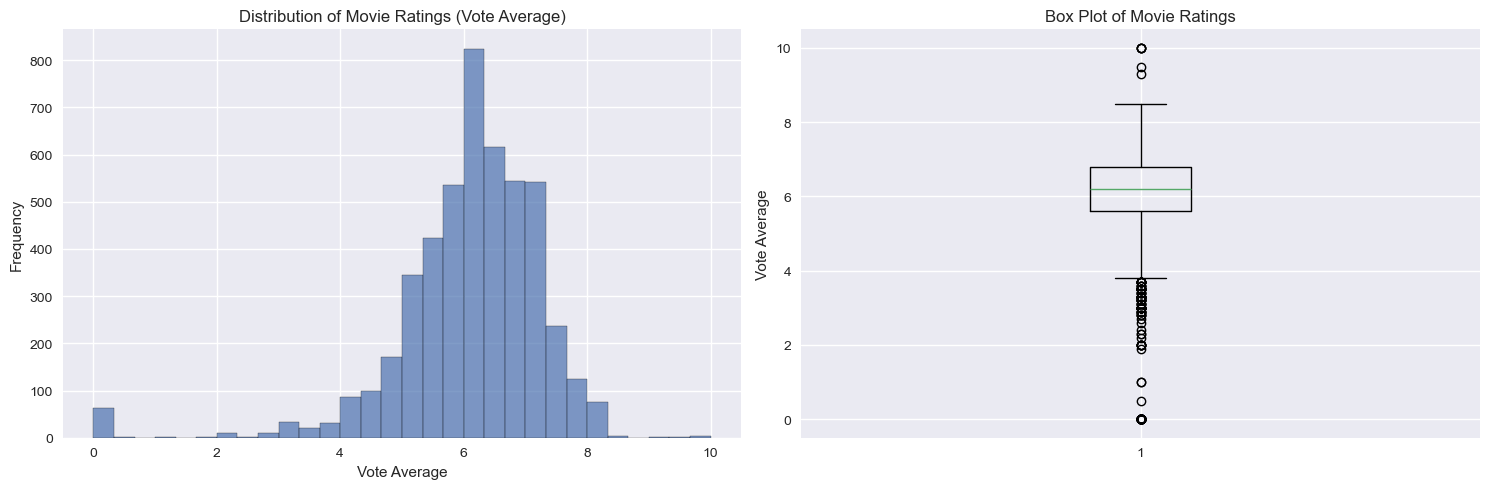

Target variable statistics:
count    4803.000000
mean        6.092172
std         1.194612
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64


In [26]:
# Target variable analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of vote_average
axes[0].hist(model_df[target], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Movie Ratings (Vote Average)')
axes[0].set_xlabel('Vote Average')
axes[0].set_ylabel('Frequency')

# Box plot
axes[1].boxplot(model_df[target])
axes[1].set_title('Box Plot of Movie Ratings')
axes[1].set_ylabel('Vote Average')

plt.tight_layout()
plt.show()

print(f"Target variable statistics:")
print(model_df[target].describe())

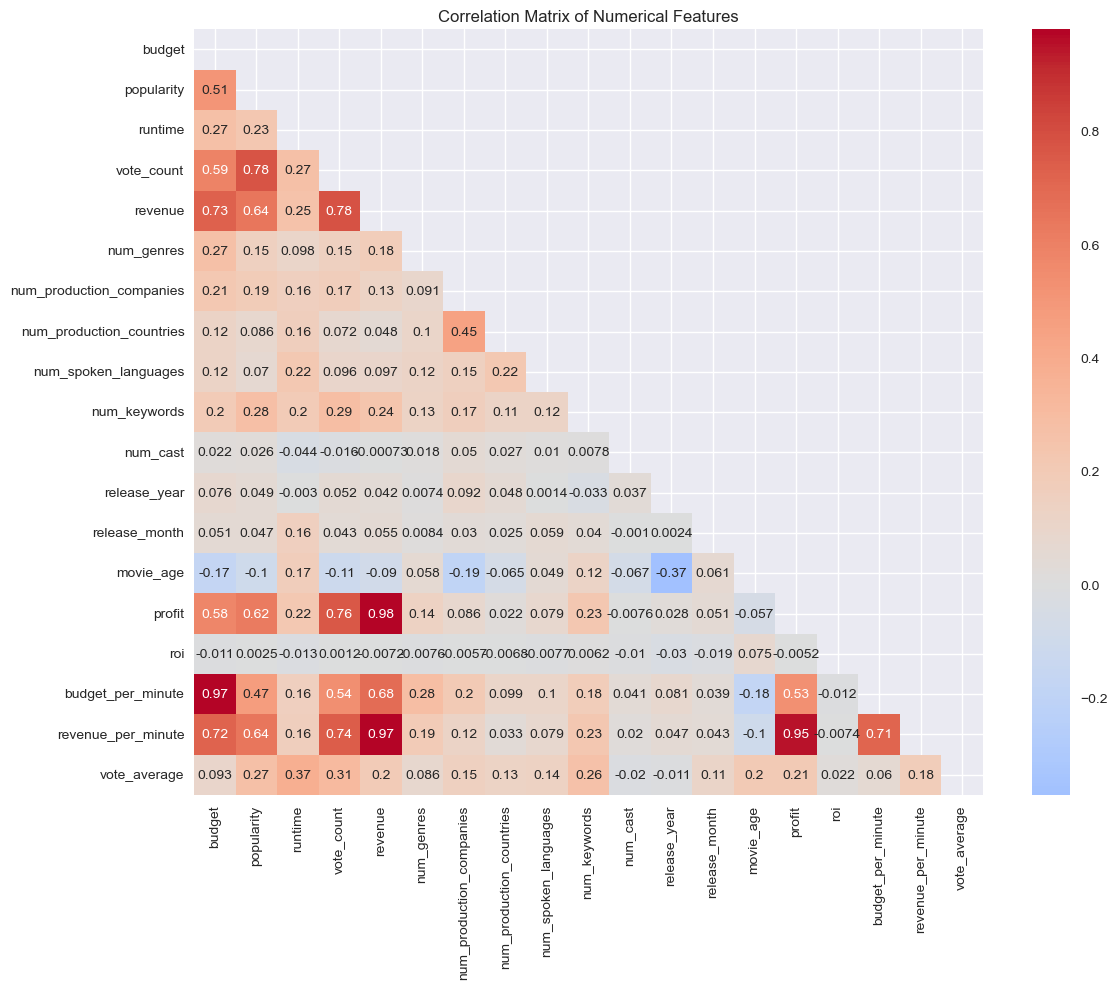

In [27]:
correlation_df = pd.concat([feature_df[numerical_features], model_df[[target]]], axis=1)

# Plot heatmap correlation
plt.figure(figsize=(12, 10))
correlation_matrix = correlation_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

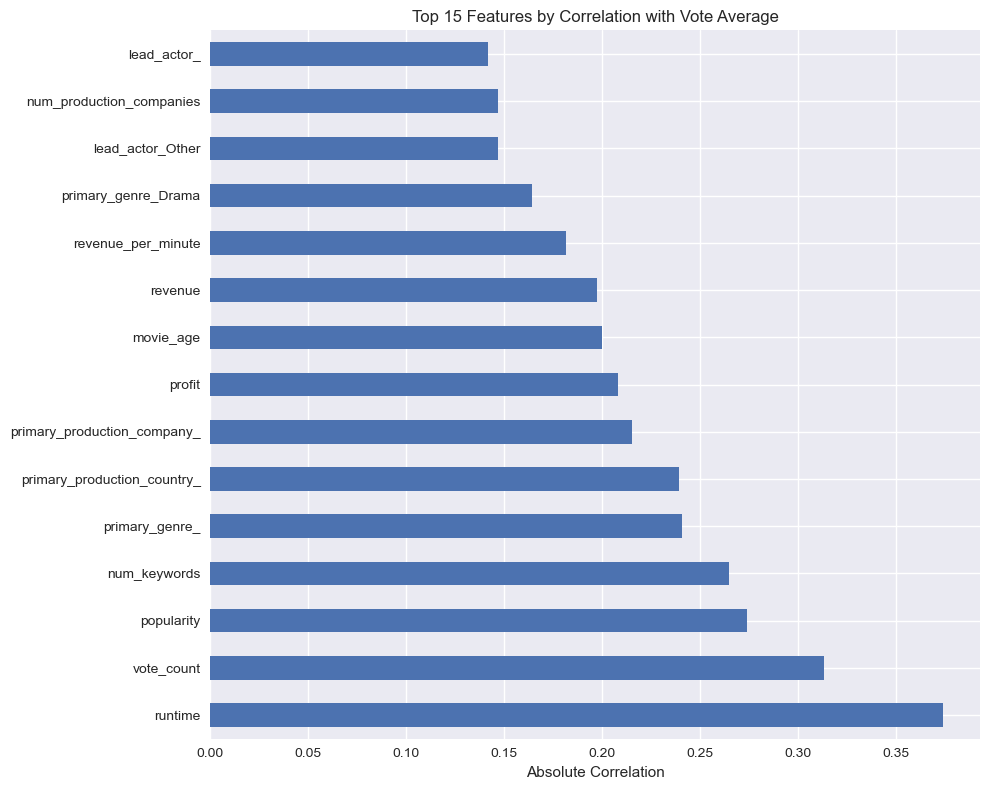

Top correlated features:
runtime                        0.374132
vote_count                     0.312997
popularity                     0.273952
num_keywords                   0.264779
primary_genre_                 0.240818
primary_production_country_    0.239212
primary_production_company_    0.215424
profit                         0.208241
movie_age                      0.199740
revenue                        0.197150
revenue_per_minute             0.181650
primary_genre_Drama            0.163971
lead_actor_Other               0.146955
num_production_companies       0.146925
lead_actor_                    0.141845
dtype: float64


In [28]:
# Feature importance analysis using correlation with target
target_correlations = feature_df.corrwith(model_df[target]).abs().sort_values(ascending=False)
top_correlations = target_correlations.head(15)

plt.figure(figsize=(10, 8))
top_correlations.plot(kind='barh')
plt.title('Top 15 Features by Correlation with Vote Average')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

print("Top correlated features:")
print(top_correlations)

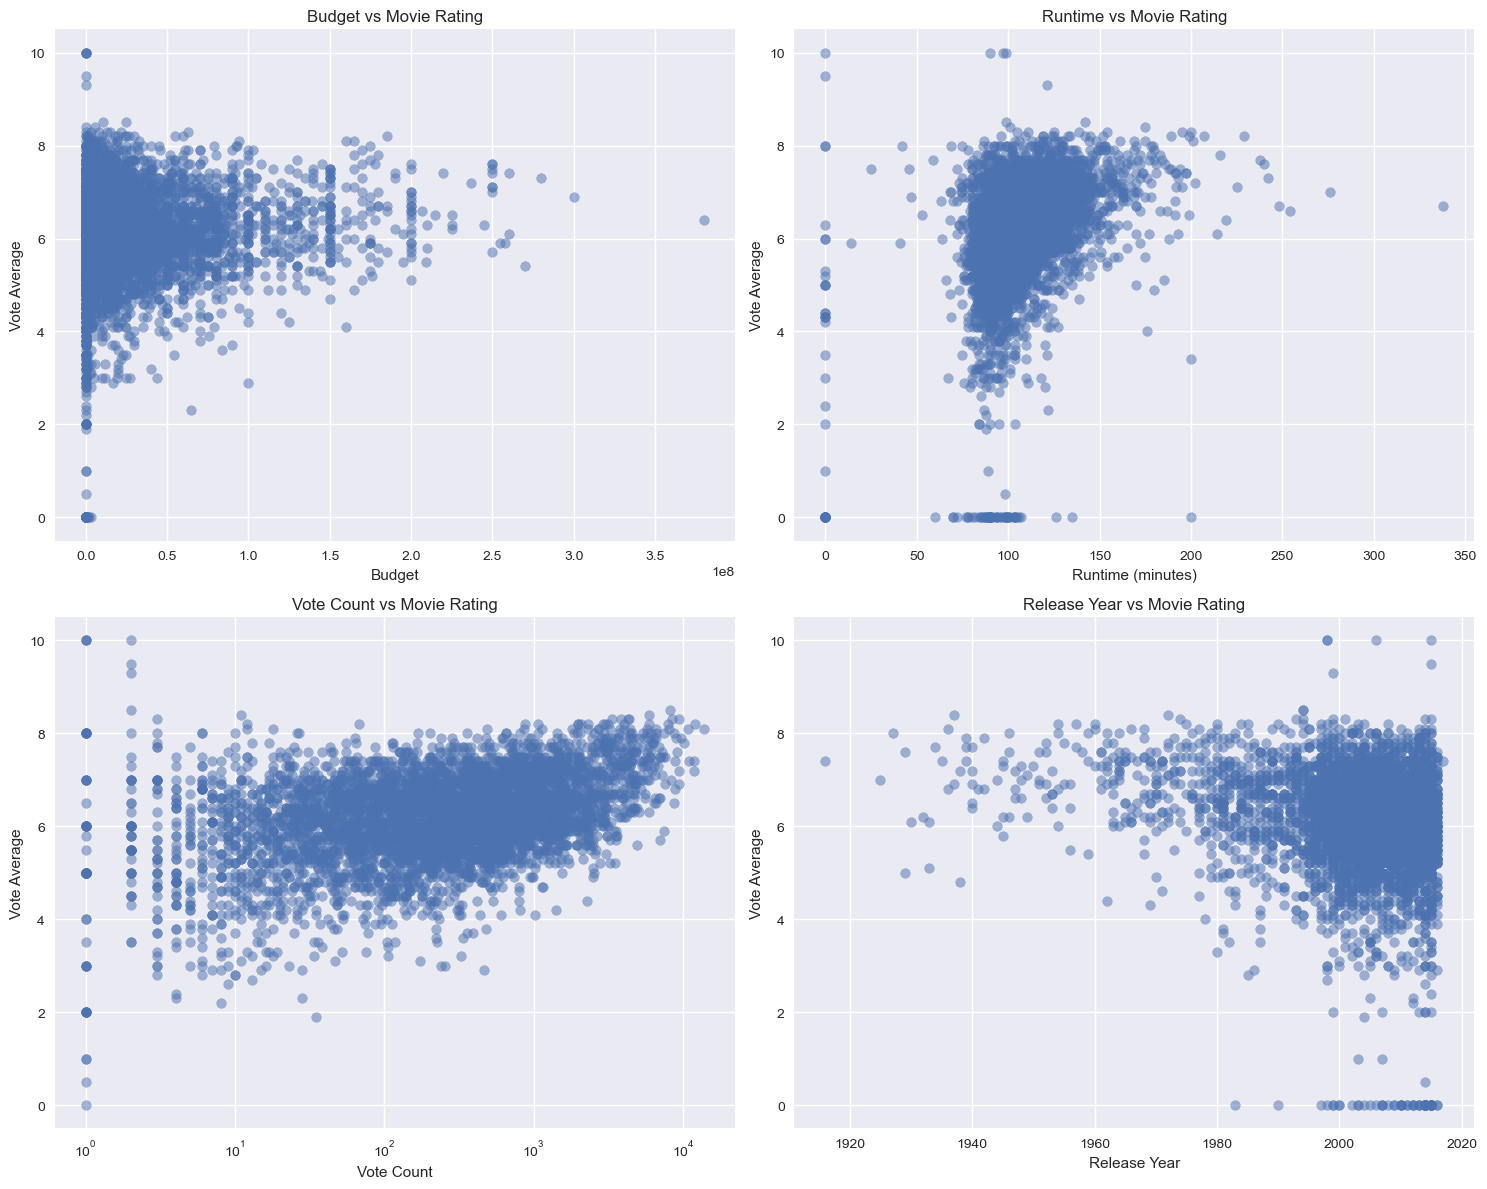

In [29]:
# Visualize relationships between key features and target
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Budget vs Rating
axes[0, 0].scatter(model_df['budget'], model_df[target], alpha=0.5)
axes[0, 0].set_xlabel('Budget')
axes[0, 0].set_ylabel('Vote Average')
axes[0, 0].set_title('Budget vs Movie Rating')

# Runtime vs Rating
axes[0, 1].scatter(model_df['runtime'], model_df[target], alpha=0.5)
axes[0, 1].set_xlabel('Runtime (minutes)')
axes[0, 1].set_ylabel('Vote Average')
axes[0, 1].set_title('Runtime vs Movie Rating')

# Vote Count vs Rating
axes[1, 0].scatter(model_df['vote_count'], model_df[target], alpha=0.5)
axes[1, 0].set_xlabel('Vote Count')
axes[1, 0].set_ylabel('Vote Average')
axes[1, 0].set_title('Vote Count vs Movie Rating')
axes[1, 0].set_xscale('log')

# Release Year vs Rating
axes[1, 1].scatter(model_df['release_year'], model_df[target], alpha=0.5)
axes[1, 1].set_xlabel('Release Year')
axes[1, 1].set_ylabel('Vote Average')
axes[1, 1].set_title('Release Year vs Movie Rating')

plt.tight_layout()
plt.show()

Top 10 most common genres:
Drama              2297
Comedy             1722
Thriller           1274
Action             1154
Romance             894
Adventure           790
Crime               696
Science Fiction     535
Horror              519
Family              513
Name: count, dtype: int64


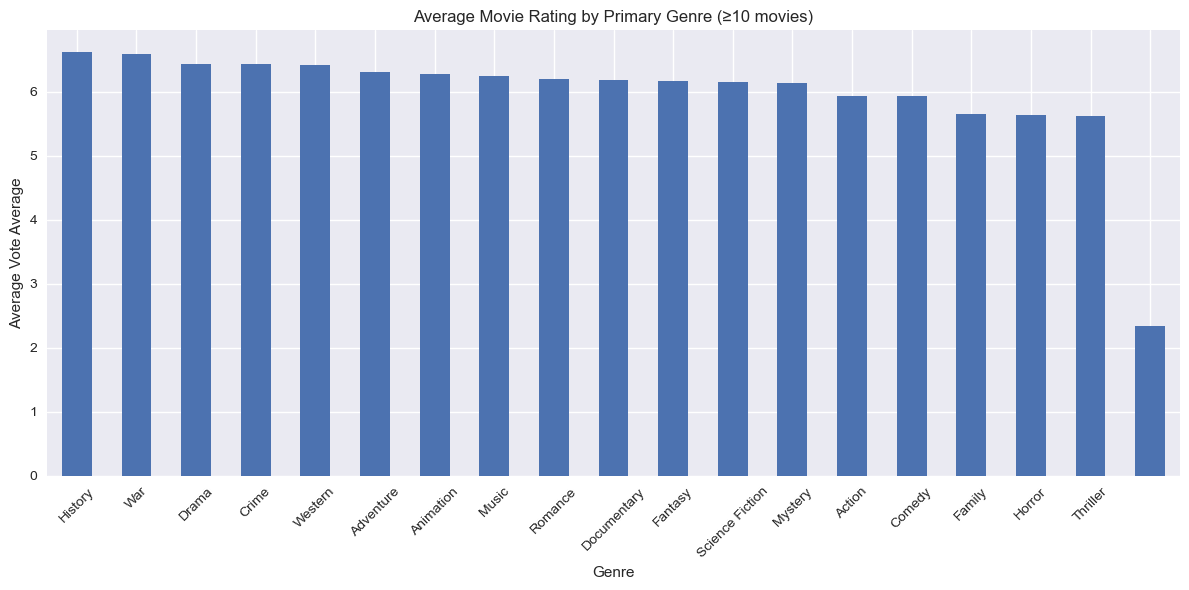

In [30]:
# Genre analysis
genre_ratings = []
for genres_list in model_df['genres_list']:
    for genre in genres_list:
        genre_ratings.append(genre)

genre_counts = pd.Series(genre_ratings).value_counts()
print("Top 10 most common genres:")
print(genre_counts.head(10))

# Average rating by primary genre
genre_avg_rating = model_df.groupby('primary_genre')[target].agg(['mean', 'count']).sort_values('mean', ascending=False)
genre_avg_rating = genre_avg_rating[genre_avg_rating['count'] >= 10]  # Filter genres with at least 10 movies

plt.figure(figsize=(12, 6))
genre_avg_rating['mean'].plot(kind='bar')
plt.title('Average Movie Rating by Primary Genre (≥10 movies)')
plt.xlabel('Genre')
plt.ylabel('Average Vote Average')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Model Building

In [32]:
# Prepare data for modeling
X = feature_df
y = model_df[target]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Feature matrix shape: (4803, 187)
Target vector shape: (4803,)
Training set shape: (3842, 187)
Test set shape: (961, 187)


In [33]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Machine': SVR(kernel='rbf', C=1.0)
}

In [35]:
# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for models that benefit from scaling
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 
                'Elastic Net', 'Support Vector Machine']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test
    
    # Train the model
    model.fit(X_train_use, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_use)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'CV_RMSE': cv_rmse,
        'predictions': y_pred,
        'model': model
    }
    
    print(f"{name} - RMSE: {rmse:.4f}, R²: {r2:.4f}, CV_RMSE: {cv_rmse:.4f}")

Training Linear Regression...
Linear Regression - RMSE: 8.5316, R²: -47.2735, CV_RMSE: 0.9973
Training Ridge Regression...
Ridge Regression - RMSE: 8.6087, R²: -48.1497, CV_RMSE: 0.9972
Training Lasso Regression...
Lasso Regression - RMSE: 1.2008, R²: 0.0437, CV_RMSE: 1.0353
Training Elastic Net...
Elastic Net - RMSE: 1.0799, R²: 0.2266, CV_RMSE: 1.0012
Training Decision Tree...
Decision Tree - RMSE: 0.9459, R²: 0.4066, CV_RMSE: 1.0601
Training Random Forest...
Random Forest - RMSE: 0.7047, R²: 0.6707, CV_RMSE: 0.7527
Training Gradient Boosting...
Gradient Boosting - RMSE: 0.6980, R²: 0.6768, CV_RMSE: 0.7497
Training Support Vector Machine...
Support Vector Machine - RMSE: 0.9854, R²: 0.3560, CV_RMSE: 0.9756


### Model Evaluation

In [37]:
# Create results summary
results_df = pd.DataFrame({
    name: {
        'RMSE': results[name]['RMSE'],
        'MAE': results[name]['MAE'], 
        'R²': results[name]['R²'],
        'CV_RMSE': results[name]['CV_RMSE']
    }
    for name in results.keys()
}).T

results_df = results_df.sort_values('RMSE')
print("Model Performance Summary:")
print(results_df.round(4))

Model Performance Summary:
                          RMSE     MAE       R²  CV_RMSE
Gradient Boosting       0.6980  0.5059   0.6768   0.7497
Random Forest           0.7047  0.5067   0.6707   0.7527
Decision Tree           0.9459  0.6915   0.4066   1.0601
Support Vector Machine  0.9854  0.6047   0.3560   0.9756
Elastic Net             1.0799  0.6675   0.2266   1.0012
Lasso Regression        1.2008  0.7128   0.0437   1.0353
Linear Regression       8.5316  0.9392 -47.2735   0.9973
Ridge Regression        8.6087  0.9420 -48.1497   0.9972


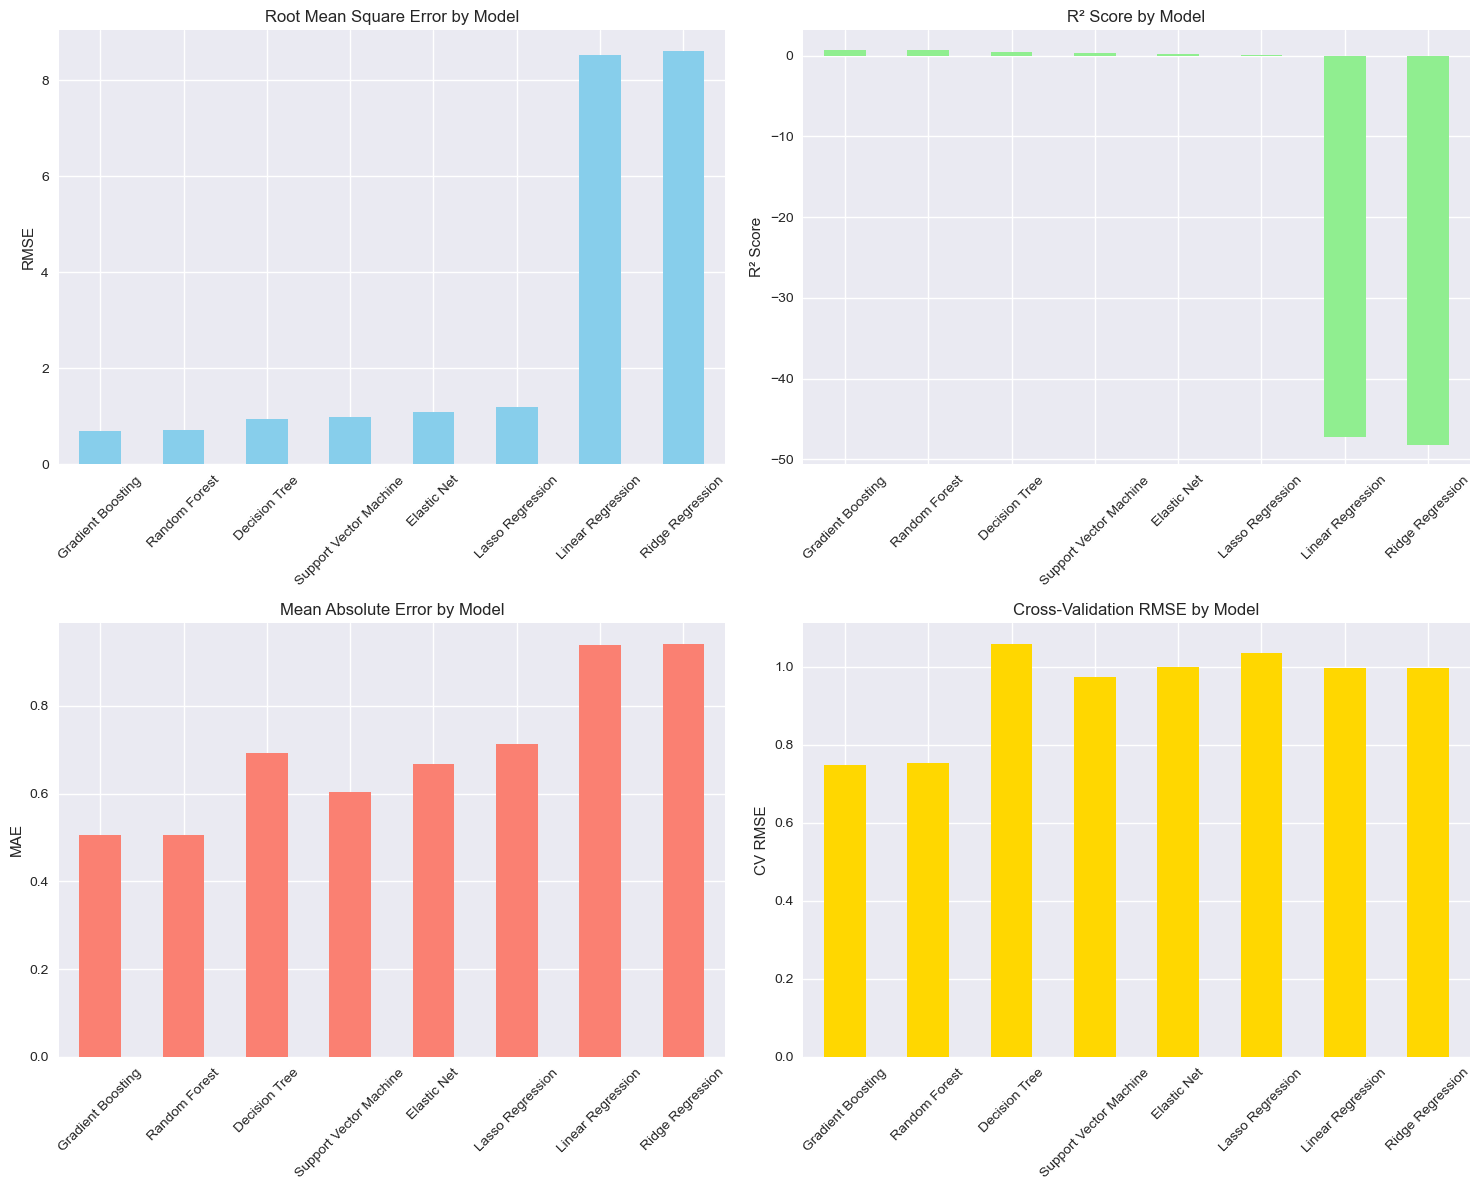

In [38]:
# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RMSE comparison
results_df['RMSE'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Root Mean Square Error by Model')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].tick_params(axis='x', rotation=45)

# R² comparison
results_df['R²'].plot(kind='bar', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('R² Score by Model')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# MAE comparison
results_df['MAE'].plot(kind='bar', ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Mean Absolute Error by Model')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].tick_params(axis='x', rotation=45)

# Cross-validation RMSE
results_df['CV_RMSE'].plot(kind='bar', ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Cross-Validation RMSE by Model')
axes[1, 1].set_ylabel('CV RMSE')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [39]:
# Get the best model
best_model_name = results_df.index[0]
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"Best performing model: {best_model_name}")
print(f"Best model RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f}")
print(f"Best model R²: {results_df.loc[best_model_name, 'R²']:.4f}")

Best performing model: Gradient Boosting
Best model RMSE: 0.6980
Best model R²: 0.6768


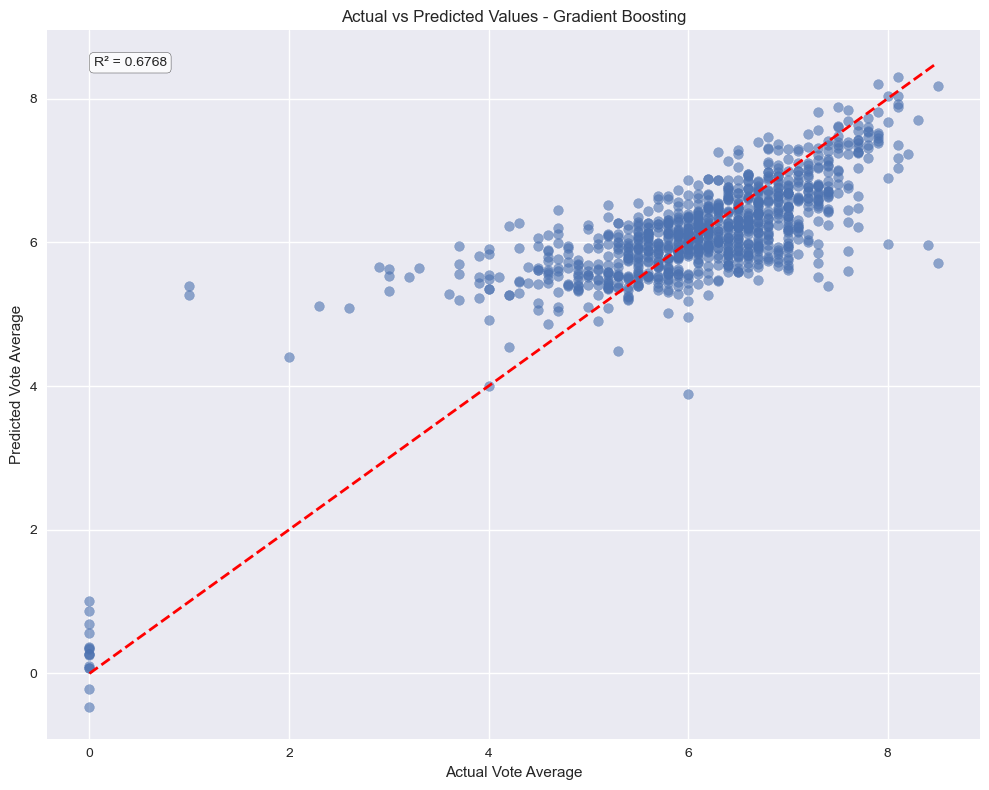

In [40]:
# Actual vs Predicted plot for best model
plt.figure(figsize=(10, 8))
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Vote Average')
plt.ylabel('Predicted Vote Average')
plt.title(f'Actual vs Predicted Values - {best_model_name}')

# Add R² score to plot
r2 = results_df.loc[best_model_name, 'R²']
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

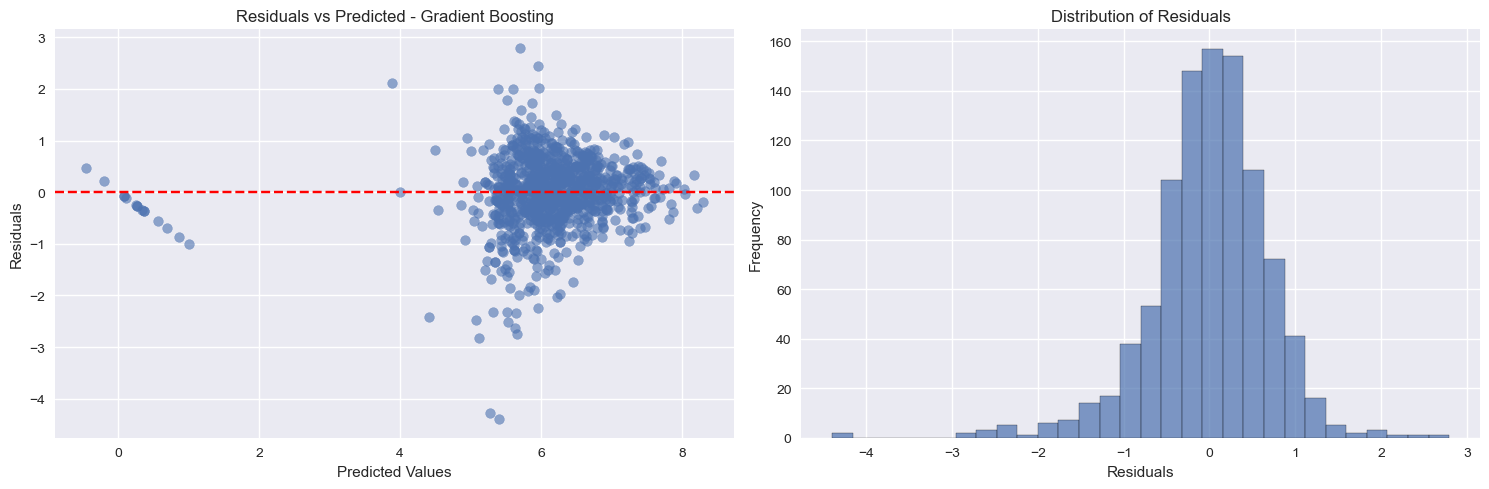

Residuals statistics:
Mean: -0.0016
Std: 0.6984


In [41]:
# Residual analysis for best model
residuals = y_test - best_predictions

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residuals vs Predicted
axes[0].scatter(best_predictions, residuals, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title(f'Residuals vs Predicted - {best_model_name}')

# Residuals distribution
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

print(f"Residuals statistics:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")

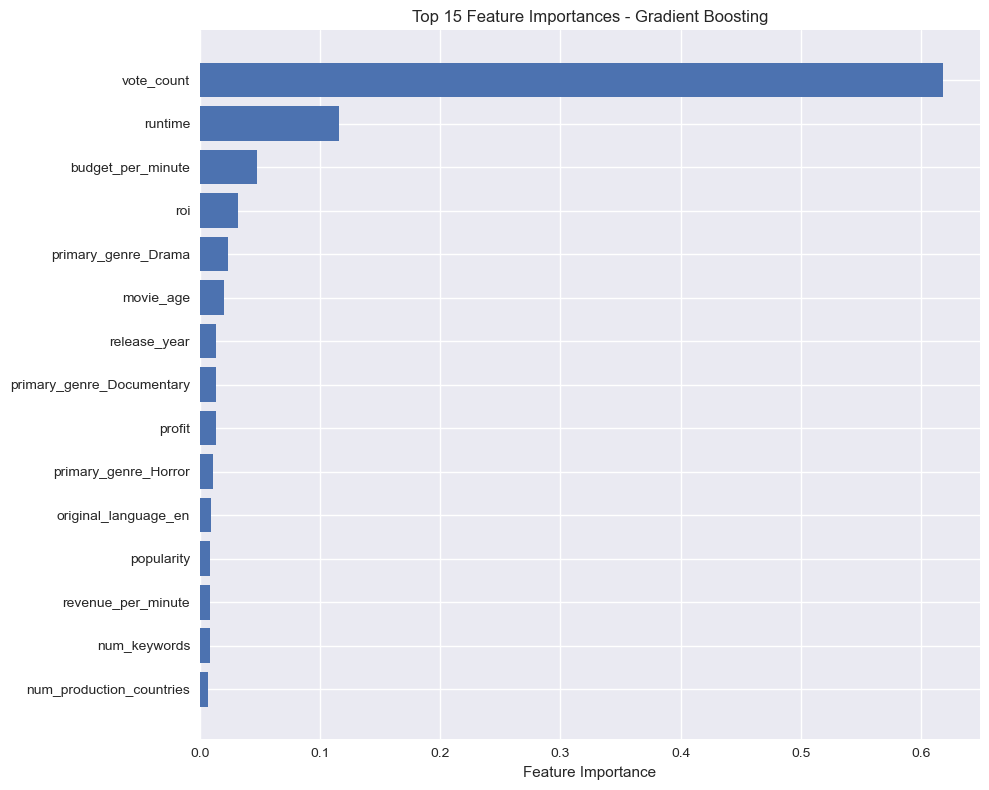

Top 10 most important features:
                      feature  importance
3                  vote_count    0.618156
2                     runtime    0.115595
16          budget_per_minute    0.047422
15                        roi    0.031499
65        primary_genre_Drama    0.023439
13                  movie_age    0.019873
11               release_year    0.013763
64  primary_genre_Documentary    0.013696
14                     profit    0.013296
70       primary_genre_Horror    0.011348


In [42]:
# Feature importance for tree-based models
if best_model_name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features:")
    print(feature_importance.head(10))

In [43]:
# Hyperparameter tuning for the best model
print(f"Performing hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestRegressor(random_state=42)
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    base_model = GradientBoostingRegressor(random_state=42)
    
elif best_model_name == 'Ridge Regression':
    param_grid = {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    }
    base_model = Ridge()
    
else:
    param_grid = {}
    base_model = best_model

if param_grid:
    # Use scaled data if needed
    if best_model_name in ['Ridge Regression', 'Lasso Regression', 'Support Vector Machine']:
        X_train_tune = X_train_scaled
        X_test_tune = X_test_scaled
    else:
        X_train_tune = X_train
        X_test_tune = X_test
    
    grid_search = GridSearchCV(
        base_model, param_grid, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train_tune, y_train)
    
    # Evaluate tuned model
    tuned_predictions = grid_search.predict(X_test_tune)
    tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_predictions))
    tuned_r2 = r2_score(y_test, tuned_predictions)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Tuned model RMSE: {tuned_rmse:.4f}")
    print(f"Tuned model R²: {tuned_r2:.4f}")
    print(f"Improvement in RMSE: {results_df.loc[best_model_name, 'RMSE'] - tuned_rmse:.4f}")

Performing hyperparameter tuning for Gradient Boosting...
Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 100}
Tuned model RMSE: 0.6865
Tuned model R²: 0.6874
Improvement in RMSE: 0.0115


### Summary

In [45]:
# Final model summary
print("="*50)
print("TMDB MOVIE RATING PREDICTION - FINAL SUMMARY")
print("="*50)
print(f"Dataset Size: {len(model_df)} movies")
print(f"Number of Features: {X.shape[1]}")
print(f"Best Model: {best_model_name}")
print(f"Test RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f}")
print(f"Test R² Score: {results_df.loc[best_model_name, 'R²']:.4f}")
print(f"Average Movie Rating: {y.mean():.2f}")
print(f"Prediction Standard Error: ±{results_df.loc[best_model_name, 'RMSE']:.2f} rating points")
print("="*50)

TMDB MOVIE RATING PREDICTION - FINAL SUMMARY
Dataset Size: 4803 movies
Number of Features: 187
Best Model: Gradient Boosting
Test RMSE: 0.6980
Test R² Score: 0.6768
Average Movie Rating: 6.09
Prediction Standard Error: ±0.70 rating points
